In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Vasicek Mean-Reverting process

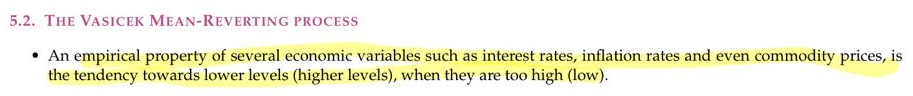
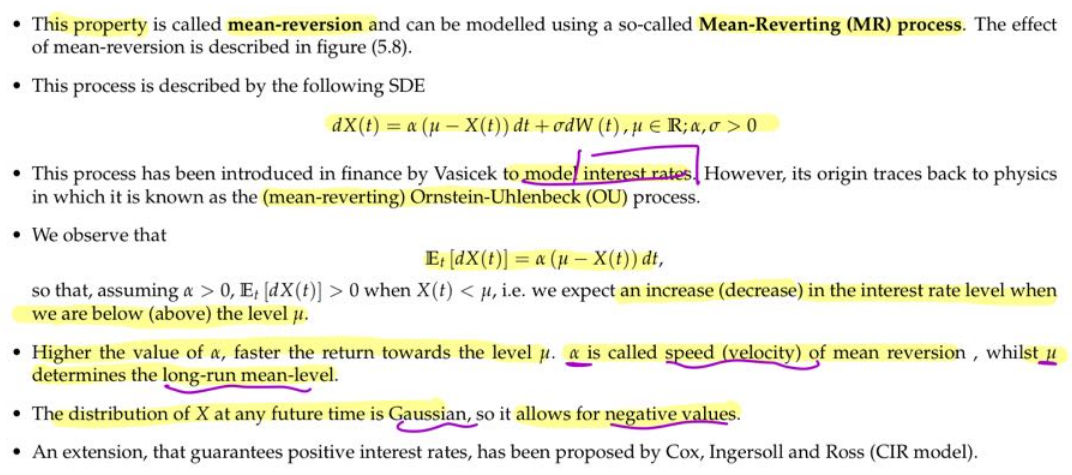
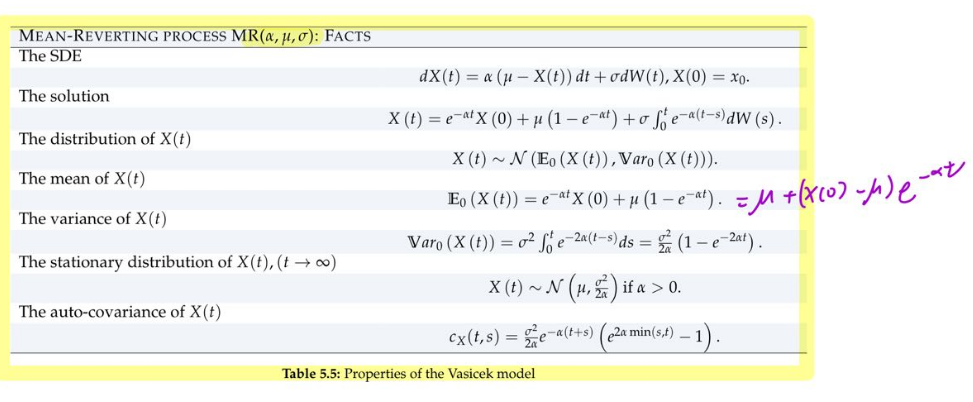

In [2]:
# Monte Carlo simulation of the Feller square-root process
# dX = alpha*(mu-X)*dt + sigma*sqrt(X)*dW
# Used in the Cox-Ingersoll-Ross model and in the Heston stochastic volatility model

# Define parameters and time grid
npaths = 2000  # number of paths
T = 1  # time horizon
nsteps = 200  # number of time steps
dt = T / nsteps  # time step
t = np.linspace(0, T, nsteps + 1)  # observation times
alpha = 5
mu = 0.07
sigma = 0.265  # model parameters
X0 = 0.03  # initial value
Feller_ratio = 2 * alpha * mu / sigma**2  # for monitoring

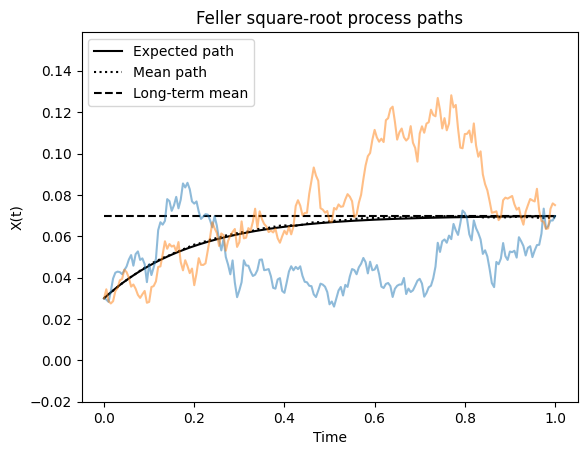

In [3]:
# Monte Carlo

# Allocate and initialise all paths
X = np.zeros((nsteps + 1, npaths))
X[0, :] = X0

# Euler-Maruyama
N = np.random.randn(nsteps, npaths)  # sample standard normal random numbers
a = sigma**2/alpha*(np.exp(-alpha*dt)-np.exp(-2*alpha*dt)) # with analytic moments
b = mu*sigma**2/(2*alpha)*(1-np.exp(-alpha*dt))**2 # with analytic moments
for i in range(nsteps):  # compute and accumulate the increments
    #X[i+1, :] = X[i, :] + alpha * (mu - X[i, :]) * dt + sigma * np.sqrt(X[i, :]) * np.sqrt(dt) * N[i, :] # plain
    X[i+1, :] = mu + (X[i,:]-mu)*np.exp(-alpha*dt)+np.sqrt(a*X[i,:]+b)*N[i,:] # with analytic moment

# Expected, mean and sample paths
plt.figure()
EX = mu + (X0 - mu) * np.exp(-alpha * t)  # expected path
plt.plot(t, EX, 'k', label='Expected path')
plt.plot(t, np.mean(X, axis=1), 'k:', label='Mean path')
plt.plot(t, mu * np.ones_like(t), 'k--', label='Long-term mean')
plt.plot(t, X[:, ::1000], alpha=0.5)  # plot a subset of paths
plt.xlabel('Time')
sdevinfty = sigma*np.sqrt(mu/(2*alpha))
plt.ylim(-0.02,mu+4*sdevinfty)
plt.ylabel('X(t)')
plt.title('Feller square-root process paths')
plt.legend()
plt.show()


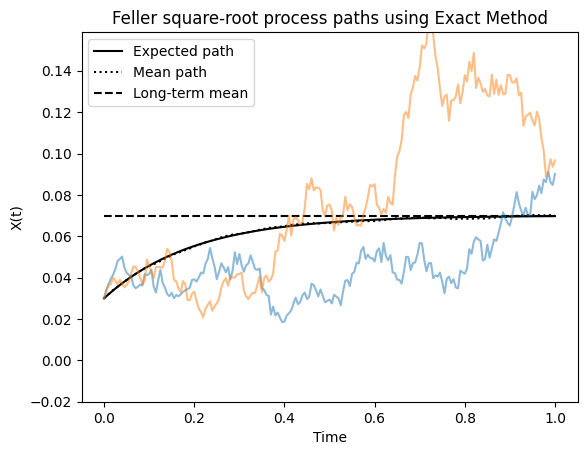

In [4]:
# Exact method
from scipy.stats import ncx2

# Exact method
d = 4 * alpha * mu / sigma**2  # degrees of freedom of the non-central chi-square distribution
k = sigma**2 * (1 - np.exp(-alpha * dt)) / (4 * alpha)

for i in range(nsteps):
    lambda_ = 4 * alpha * X[i, :] / (sigma**2 * (np.exp(alpha * dt) - 1))
    # Generating random variables from the non-central chi-squared distribution
    #X[i + 1, :]=ncx2.ppf(np.random.rand(npaths), df=d, nc=lambda_) * k # Calculate the ICDF (inverse of the 非中心卡方分布CDF)，df 是自由度，nc 是非中心参数，q 是概率值
    X[i + 1, :] = ncx2.rvs(d,lambda_,size=npaths) * k # ncx2 指的是非中心卡方（non-central chi-square）分布。.rvs 方法代表 "random variates"，意思是用来从非中心卡方分布生成随机数

# Note: The commented out MATLAB line using 'icdf' is equivalent to using the 'ppf' (percent point function)
# method in scipy.stats, which is the inverse of the CDF. However, for generating random variables, rvs is used.

# Expected, mean and sample paths
plt.figure()
EX = mu + (X0 - mu) * np.exp(-alpha * t)  # expected path
plt.plot(t, EX, 'k', label='Expected path')
plt.plot(t, np.mean(X, axis=1), 'k:', label='Mean path')
plt.plot(t, mu * np.ones_like(t), 'k--', label='Long-term mean')
plt.plot(t, X[:, ::1000], alpha=0.5)  # plot a subset of paths
plt.xlabel('Time')
plt.ylabel('X(t)')
sdevinfty = sigma*np.sqrt(mu/(2*alpha))
plt.ylim(-0.02,mu+4*sdevinfty)
plt.title('Feller square-root process paths using Exact Method')
plt.legend()
plt.show()


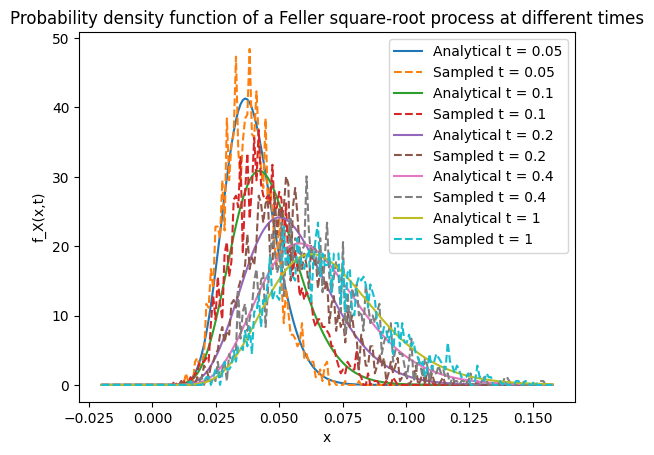

In [5]:
# Probability density function at different times
# Parameters
t2 = [0.05, 0.1, 0.2, 0.4, 1]
x = np.linspace(-0.02, mu + 4 * sdevinfty, 200)
k = sigma**2 * (1 - np.exp(-alpha * np.array(t2))) / (4 * alpha)
d = 4 * alpha * mu / sigma**2
lambda_ = 4 * alpha * X0 / (sigma**2 * (np.exp(alpha * np.array(t2)) - 1))  # Non-centrality parameter

# Arrays for analytical and sampled PDFs
fa = np.zeros((len(x)-1, len(t2)))
fs = np.zeros((len(x)-1, len(t2)))

# Calculate the PDFs in a single loop
for i, time in enumerate(t2):
    lambda_ = 4 * alpha * X0 / (sigma**2 * (np.exp(alpha * time) - 1))  # Non-centrality parameter
    fa[:, i] = ncx2.pdf(x[:-1] / k[i], d, lambda_) / k[i]  # Analytical PDF
    fs[:, i], _ = np.histogram(X[int(time * nsteps), :], bins=x, density=True)  # Sampled PDF

# Plotting the PDFs
plt.figure()
for i, time in enumerate(t2):
    plt.plot(x[:-1], fa[:, i], label=f'Analytical t = {time}')
    plt.plot(x[:-1], fs[:, i], '--', label=f'Sampled t = {time}')

plt.xlabel('x')
plt.ylabel('f_X(x,t)')
plt.title('Probability density function of a Feller square-root process at different times')
plt.legend()
plt.show()  # Display the plot

# CIR

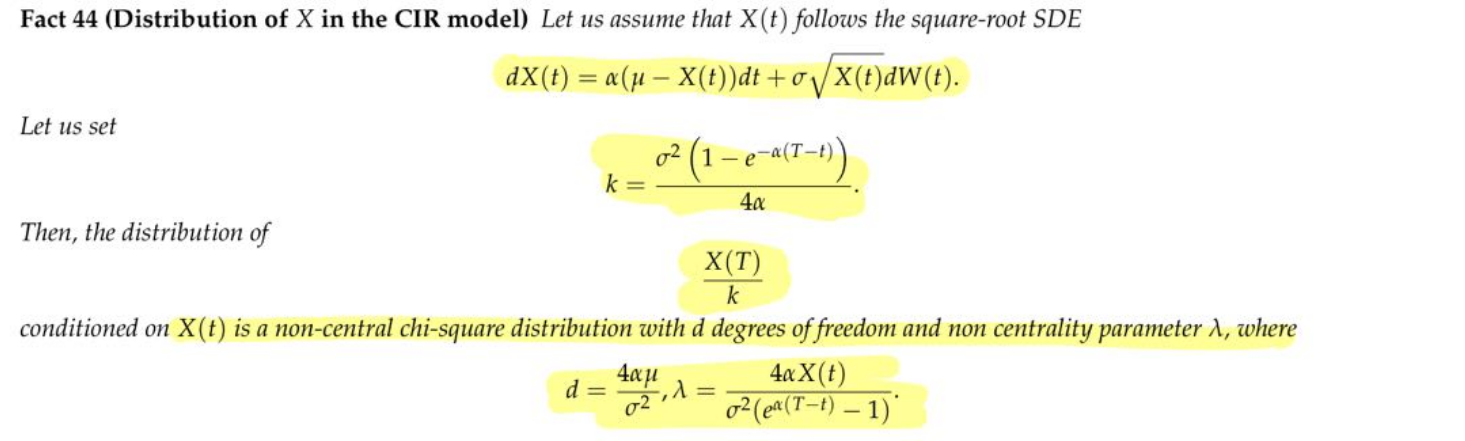
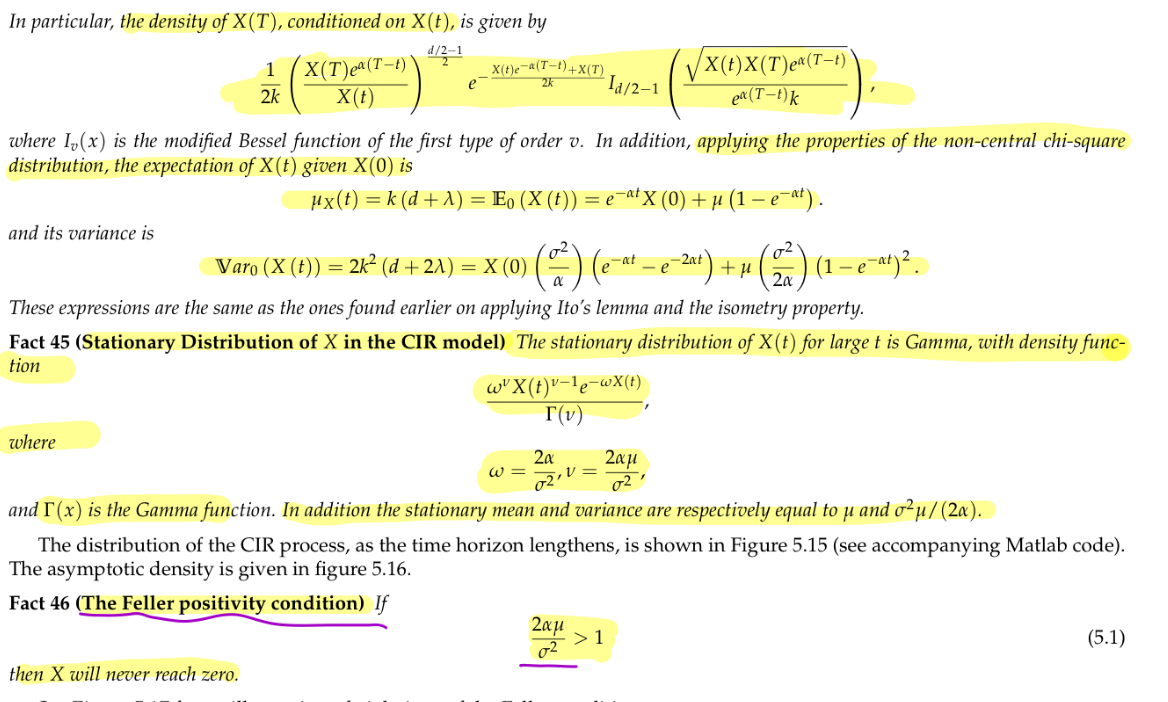
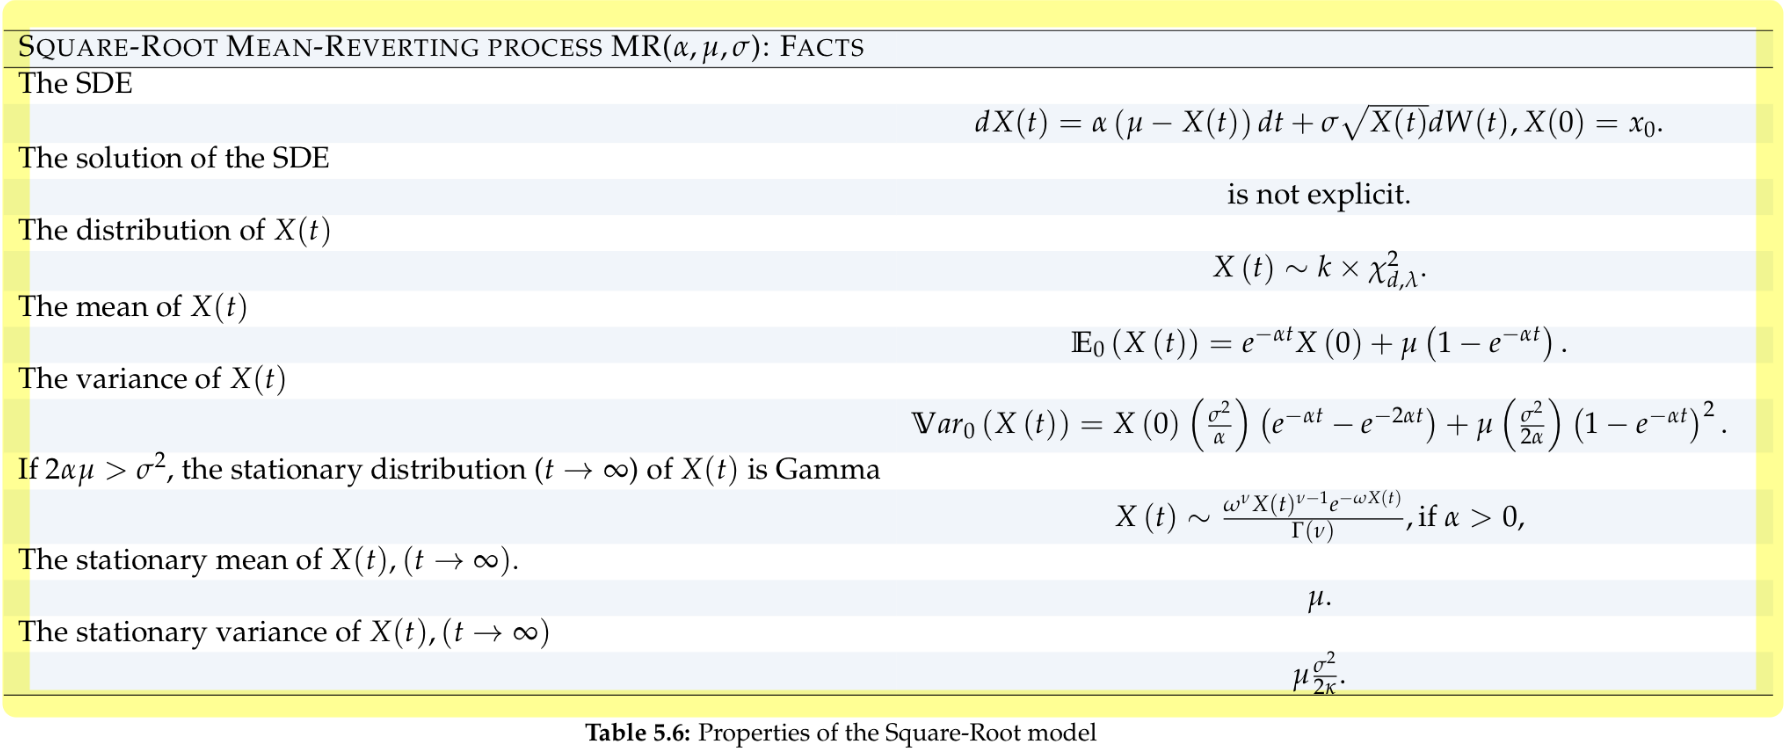

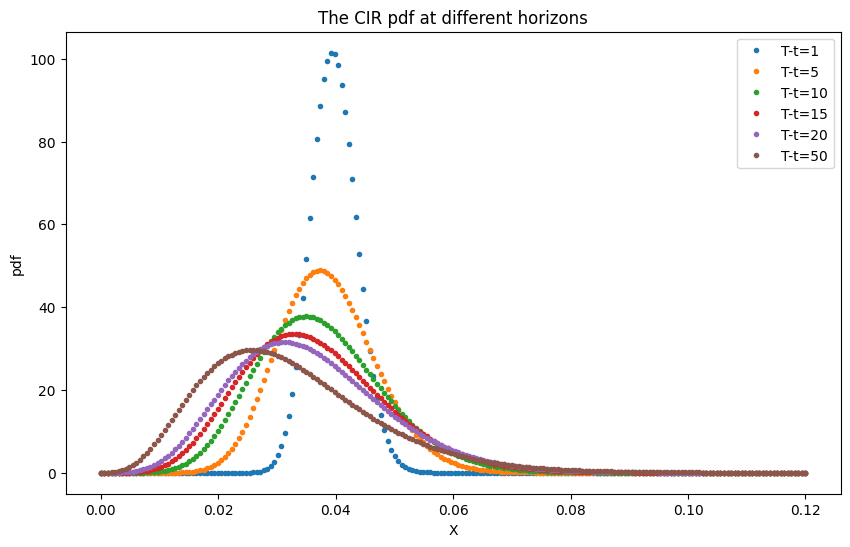

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2
from scipy.integrate import trapz

# Define parameters
alpha = 0.03
sigma = 0.02
Xt = 0.04
mu = 0.03
tau = np.array([1, 5, 10, 15, 20, 50])

# Compute d
d = 4 * alpha * mu / sigma**2

# Grid values for X
XT = np.linspace(0, 0.12, 200)
pdfcir = np.zeros((len(XT), len(tau)))
EXTnum = np.zeros(len(tau))

# Compute the PDF for different tau values
for i, t in enumerate(tau):
    lambda_ = 4 * alpha * Xt / (sigma**2 * (np.exp(alpha * t) - 1))
    k = sigma**2 * (1 - np.exp(-alpha * t)) / (4 * alpha)
    pdfcir[:, i] = ncx2.pdf(XT / k, d, lambda_) / k
    # check expected value
    EXTnum[i] = trapz(XT, XT * pdfcir[:, i])

# Plotting
plt.figure(figsize=(10, 6))
for i in range(len(tau)):
    plt.plot(XT, pdfcir[:, i], '.', label=f'T-t={tau[i]}')
plt.xlabel('X')
plt.ylabel('pdf')
plt.title('The CIR pdf at different horizons')
plt.legend()
plt.show()


# Extended CIR (ECIR)：An interesting generalization of the CIR model is obtained by considering time dependent coefficients

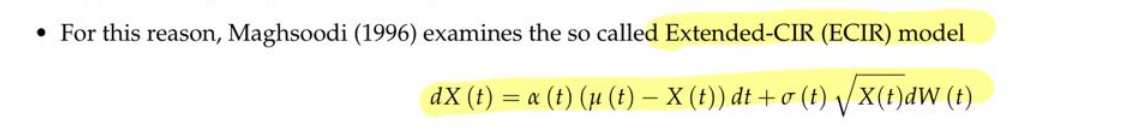

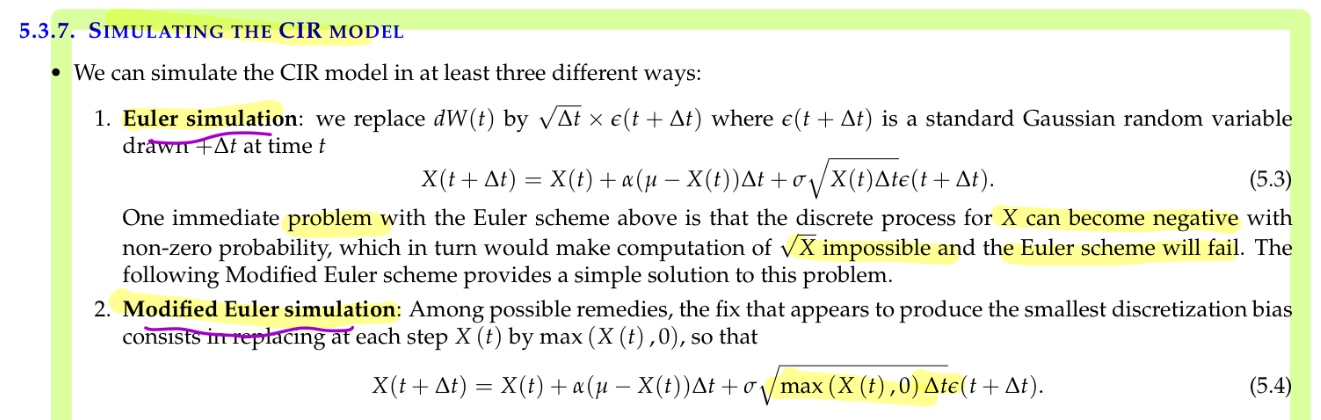
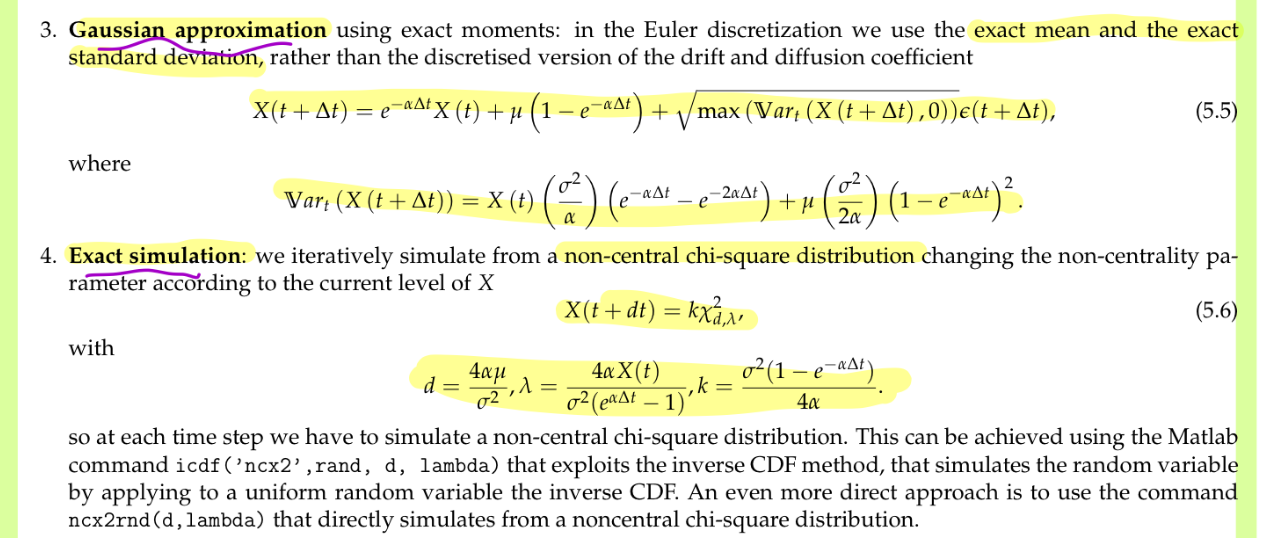
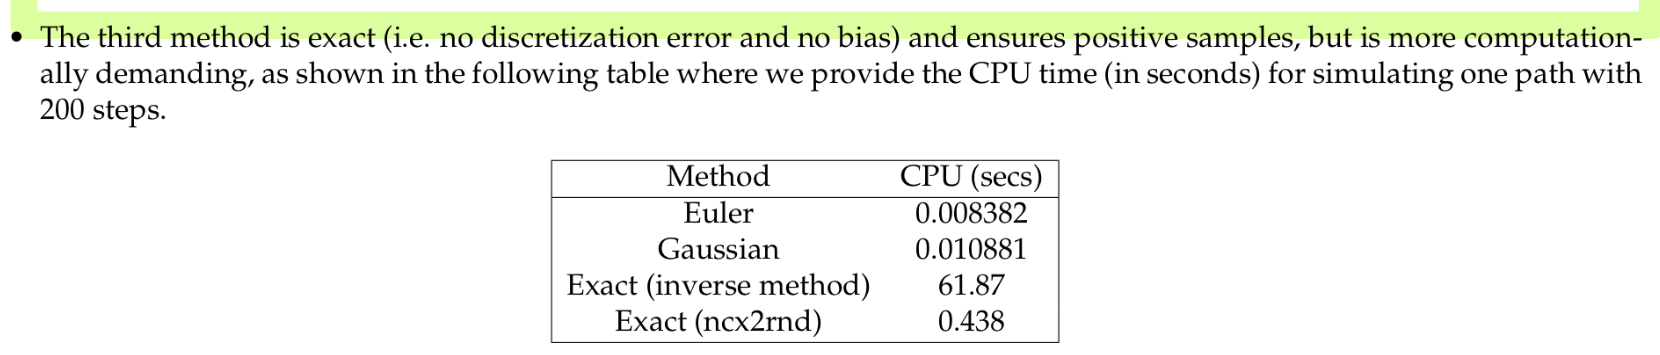

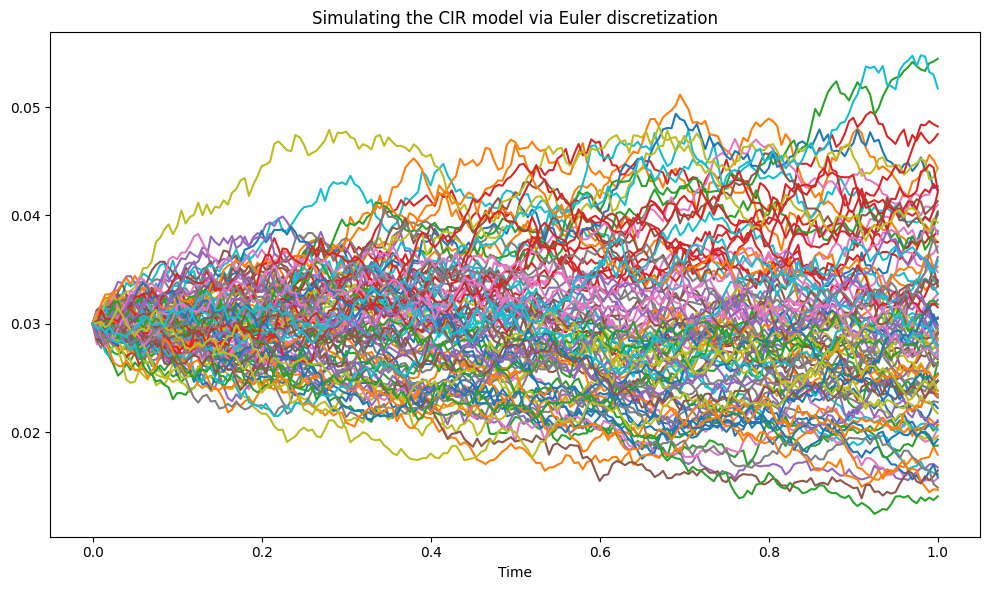

In [7]:
#############################################
#### Simulating the CIR Model: Euler discretization
#############################################
# Model parameters
alpha = 0.01
sigma = 0.05
Xt = 0.03
mu = 0.05

# Simulation parameters
nstep = 200
horizon = 1
nsimul = 100
dt = horizon / nstep

# Preallocate variable to store simulated values
Xall = np.zeros((nstep + 1, nsimul))

# Simulate the CIR model
for j in range(nsimul):
    X = np.zeros(nstep + 1)
    X[0] = Xt
    for i in range(1, nstep + 1):
        X[i] = X[i - 1] + alpha * (mu - X[i - 1]) * dt + sigma * np.sqrt(X[i - 1]*dt) * np.random.randn()
    Xall[:, j] = X

# Plot simulations
plt.figure(figsize=(10, 6))
plt.plot(dt * np.arange(nstep + 1), Xall)
plt.xlabel('Time')
plt.title('Simulating the CIR model via Euler discretization')
plt.tight_layout()
plt.show()  # Display the plot

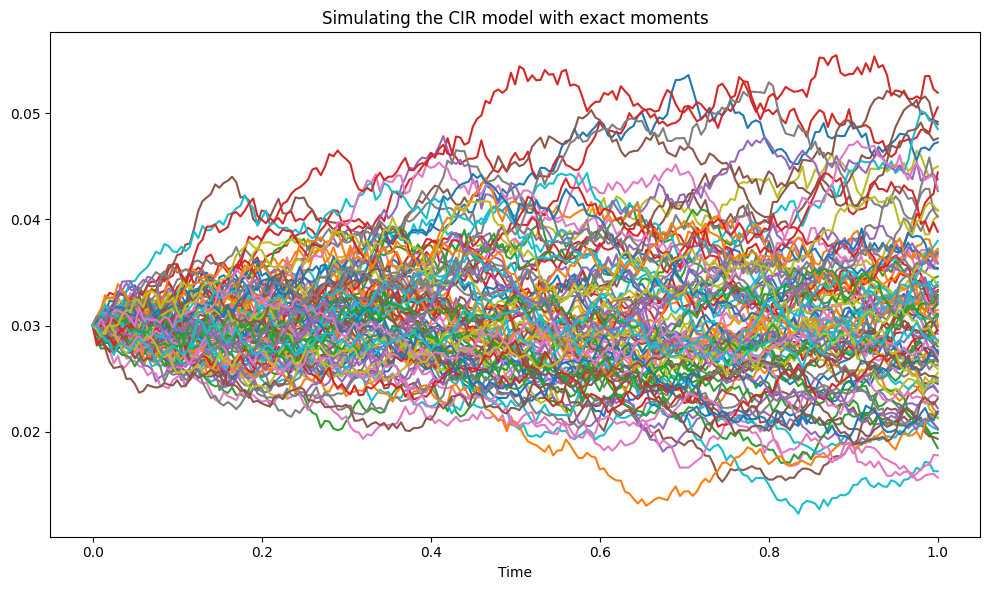

In [8]:
#############################################
#### Simulating the CIR Model: Gaussian Approximation (exact moments)
#############################################

# Model parameters
alpha = 0.01
sigma = 0.05
Xt = 0.03
mu = 0.05

# Simulation parameters
nstep = 200
horizon = 1
nsimul = 100
dt = horizon / nstep

# Preallocate array to store simulated values
Xall = np.zeros((nstep + 1, nsimul))

# Simulate the CIR model using Gaussian approximation
for j in range(nsimul):
    X = np.zeros(nstep + 1)
    X[0] = Xt
    for i in range(nstep):
        m = np.exp(-alpha * dt) * X[i] + mu * (1 - np.exp(-alpha * dt))
        v = (X[i] * (sigma**2) / alpha) * (np.exp(-alpha * dt) - np.exp(-2 * alpha * dt)) \
            + mu * (sigma**2 / (2 * alpha)) * (1 - np.exp(-alpha * dt))**2
        X[i + 1] = m + np.sqrt(v) * np.random.randn()
    Xall[:, j] = X

# Plot simulations
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(dt * np.arange(nstep + 1), Xall)
plt.xlabel('Time')
plt.title('Simulating the CIR model with exact moments')
plt.tight_layout()
plt.show()  # Display the plot


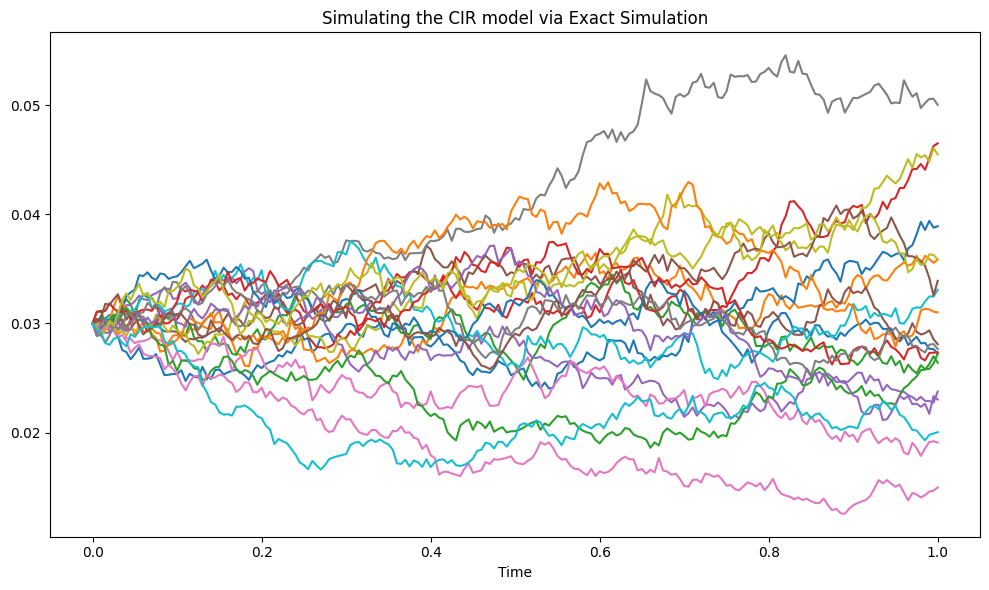

In [9]:
#############################################
#### Simulating the CIR Model: Gaussian Approximation (exact method)
#############################################

# CIR Parameters
alpha = 0.01
sigma = 0.05
Xt = 0.03
mu = 0.05

# Simulation parameters
nstep = 200
horizon = 1
nsimul = 20
dt = horizon / nstep

# Compute 'd' and 'k' for the non-central chi-squared distribution
d = 4 * alpha * mu / sigma**2
k = sigma**2 * (1 - np.exp(-alpha * dt)) / (4 * alpha)

# Variable to store simulated values
Xall = np.zeros((nstep + 1, nsimul))

# Start simulations
for j in range(nsimul):
    X = np.zeros(nstep + 1)
    X[0] = Xt
    for i in range(nstep):
        lambda_ = 4 * alpha * X[i] / (sigma**2 * (np.exp(alpha * dt) - 1))
        # Simulate the next step using the non-central chi-squared distribution
        X[i + 1] = ncx2.rvs(d, lambda_) * k
    Xall[:, j] = X

# Plot simulations
plt.figure(figsize=(10, 6), facecolor='white')  
plt.plot(dt * np.arange(nstep + 1), Xall)
plt.xlabel('Time')
plt.title('Simulating the CIR model via Exact Simulation')
plt.tight_layout()
plt.show()  # Display the plot


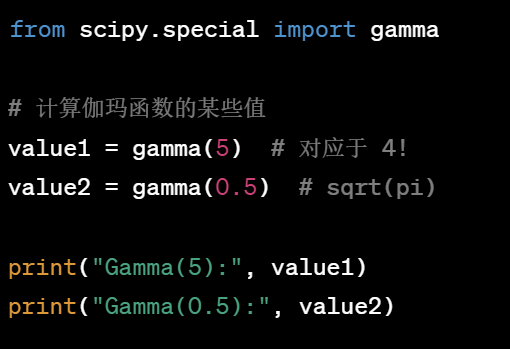